In [1]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import seaborn as sns
import numpy as np
import boto3
import pandas as pd
from sagemaker import get_execution_role
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout, SpatialDropout1D, Input, concatenate
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.keras.backend import set_session

In [2]:
role = get_execution_role()
bucket='sagemaker-tagger'
data_key1 = 'update_twelve_three.csv'
data_location1 = 's3://{}/{}'.format(bucket, data_key1)

df = pd.read_csv(data_location1)

In [3]:
df['Message'][0]

'Dear AVRAHAM JACOBSOHN,  This is to confirm that a card payment for 142.48 was made to your Grange account ending in 1173 using the card ending in 2308.  Confirmation Number: 6786423  Scheduled Payment Date: 11/08/2019  Payment Amount: 142.48  Last 4 of Card: 2308  Please contact Grange Insurance at 1-800-425-1100 if you have any questions.  Sincerely,  Grange Insurance  Please note:  This email message was sent from a notification-only address that cannot accept incoming email.  Please do not reply to this message.  '

In [4]:
# Change the name of the column with From + Subject + Message

df.rename(columns={'text':'Combined_Text'}, inplace=True)

In [5]:
# Function to clean the text prior to tokenizing

def clean_text(text):
    # Perform a few cleaning steps to remove non-alphabetic characters
    
    text = text.replace("\n", " ").replace("\r", " ")

    text = text.strip(" ")
    
    punc_list = '!@#$%^&*()+?-_=:.<>[]{}/\~",©' + '1234567890'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.translate(t)
    
    return text

In [6]:
# Clean the From Message and Subject before separating to different models

df['Clean_Message'] = df['Message'].apply(clean_text)

df['Clean_From'] = df['From'].apply(clean_text)

df['Clean_Subject'] = df['Subject'].apply(clean_text)

df['Combined_Text'] = df['Combined_Text'].apply(clean_text)

In [7]:
df.head()

,From,Message,Subject,Tags,UID,Combined_Text,tag_list,first_tag,sender_name,sender_email,domain_name,isNoReply,Clean_Message,Clean_From,Clean_Subject
0,<grangepayments@westernunionspeedpay.com>,"Dear AVRAHAM JACOBSOHN, This is to confirm th...",Grange Payment Confirmation,Finance,31780,grangepayments westernunionspeedpay com Gran...,['Finance'],Finance,NaN,grangepayments@westernunionspeedpay.com,westernunionspeedpay,False,Dear AVRAHAM JACOBSOHN This is to confirm th...,grangepayments westernunionspeedpay com,Grange Payment Confirmation
1,Chase <no.reply.alerts@chase.com>,This is an Alert to help manage your account ...,Your Debit Card Transaction,Finance,31779,Chase no reply alerts chase com Your Debit C...,['Finance'],Finance,Chase,no.reply.alerts@chase.com,chase,True,This is an Alert to help manage your account e...,Chase no reply alerts chase com,Your Debit Card Transaction
2,Amazon Web Services <no-reply-aws@amazon.com>,Please let us know if we helped resolve your i...,Resolved 6559329691: Limit Increase: SageMaker,Productivity,31738,Amazon Web Services no reply aws amazon com ...,['Productivity'],Productivity,Amazon Web Services,no-reply-aws@amazon.com,amazon,True,Please let us know if we helped resolve your i...,Amazon Web Services no reply aws amazon com,Resolved Limit Increase SageMaker
3,Lambda Labs <noreply@github.com>,Youve been added to the Labs 18 - Tagger team ...,Bernie Durfee added you to the Lambda Labs tea...,Productivity,31693,Lambda Labs noreply github com Bernie Durfee...,['Productivity'],Productivity,Lambda Labs,noreply@github.com,github,True,Youve been added to the Labs Tagger team ...,Lambda Labs noreply github com,Bernie Durfee added you to the Lambda Labs tea...
4,Amazon Web Services <no-reply-aws@amazon.com>,"Hello, We haven't heard back from you regard...",Attention required on case 6559329691: Limit I...,Productivity,31684,Amazon Web Services no reply aws amazon com ...,['Productivity'],Productivity,Amazon Web Services,no-reply-aws@amazon.com,amazon,True,Hello We haven't heard back from you regardi...,Amazon Web Services no reply aws amazon com,Attention required on case Limit I...


In [8]:
df['tag_list'].value_counts()

['Finance']                      5604
['Entertainment']                1505
['Shopping']                     1065
['Personal', 'Other']             685
['Other']                         514
['Productivity']                  514
['Personal', 'Productivity']      382
['Social']                        146
['Productivity', 'Events']        130
['Entertainment', 'Finance']      102
['Events']                         95
['Personal', 'Shopping']           95
['Personal', 'Events']             95
['Travel']                         92
['Personal', 'Finance']            69
['Personal', 'Travel']             25
['Personal', 'Entertainment']      19
['Shopping', 'Finance']            13
['Entertainment', 'Shopping']      10
['Events', 'Productivity']          8
['Travel', 'Finance']               5
['Productivity', 'Finance']         4
['Personal', 'Social']              4
['Shopping', 'Entertainment']       4
['Social', 'Productivity']          4
['Shopping', 'Productivity']        2
['Finance', 

In [9]:
df['Tags'].value_counts()

Finance                    5604
Entertainment              1505
Shopping                   1065
Personal, Other             685
Productivity                514
Other                       514
Personal, Productivity      382
Social                      146
Productivity, Events        130
Entertainment, Finance      102
Events                       95
Personal, Events             95
Personal, Shopping           95
Travel                       92
Personal, Finance            69
Personal, Travel             25
Personal, Entertainment      19
Shopping, Finance            13
Entertainment, Shopping      10
Events, Productivity          8
Travel, Finance               5
Social, Productivity          4
Shopping, Entertainment       4
Personal, Social              4
Productivity, Finance         4
Shopping, Productivity        2
Finance, Travel               2
Finance, Events               1
Productivity, Shopping        1
Finance, Productivity         1
Finance, Shopping             1
Events, 

In [10]:
# Creating Personal Column

df['Personal'] = df['Tags'].str.contains('Personal')
df['Personal'].value_counts()

False    9824
True     1374
Name: Personal, dtype: int64

In [11]:
# Applying length of CLEAN messages as feature

df['Clean_Text_Length'] = df['Clean_Message'].apply(len)
print(df['Clean_Text_Length'].min(), df['Clean_Text_Length'].max())

0 3732402


In [12]:
# Most lengths are below 5000 even with a max of 370k length

clean_text_length = df['Clean_Text_Length'] < 5000
clean_text_length.value_counts()

True     10544
False      654
Name: Clean_Text_Length, dtype: int64

In [13]:
# lemmatizer = WordNetLemmatizer()

# def regnltk_tokenize(text):
#     text = clean_text(text)
#     words = regexp_tokenize(text, pattern = '\s+', gaps = True)
#     return [lemmatizer.lemmatize(word.lower()) for word in words if (len(word) >= 3)] 

In [14]:
# Remove too small and too large texts from the messages before tokenizing

message_values = df['Combined_Text'].values

tokens = []

for i in range(len(message_values)):
    value = message_values[i]
    value = value.split(" ")
    value = [x for x in value if len(x) > 3 and len(x) < 20]
    value = " ".join(value)
    tokens.append(value)

## Start of Keras Work

In [15]:
# Starting tokenizing from keras preprocessing

tokenizer = Tokenizer(num_words=5000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, split=' ')
tokenizer.fit_on_texts(tokens)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# saving
with open('final_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Found 407235 unique tokens.


In [16]:
# Split the data into train/test prior to prepping for each model

X = df.drop(columns=['tag_list', 'first_tag'])

Y = df['first_tag']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(10078, 15) (10078,)
(1120, 15) (1120,)


#### Format all of the inputs for each Model

In [17]:
# Format the inputs for Model 1 of predicting tag from message body

Message_X_train = tokenizer.texts_to_sequences(X_train['Clean_Message'].values)
Message_X_train = pad_sequences(Message_X_train, maxlen=5000)
print('Shape of data tensor:', Message_X_train.shape)

Message_X_test = tokenizer.texts_to_sequences(X_test['Clean_Message'].values)
Message_X_test = pad_sequences(Message_X_test, maxlen=5000)
print('Shape of data tensor:', Message_X_test.shape)

Shape of data tensor: (10078, 5000)
Shape of data tensor: (1120, 5000)


In [18]:
# Format the inputs for Model 2 of predicting tag from message subject

# First need to get length of subject messages

clean_subject_length = df['Clean_Subject'].apply(len)
(clean_subject_length < 150).value_counts()

# Most are below 150 in length, will use this to pad

Subject_X_train = tokenizer.texts_to_sequences(X_train['Clean_Subject'].values)
Subject_X_train = pad_sequences(Subject_X_train, maxlen=150)
print('Shape of data tensor:', Subject_X_train.shape)

Subject_X_test = tokenizer.texts_to_sequences(X_test['Clean_Subject'].values)
Subject_X_test = pad_sequences(Subject_X_test, maxlen=150)
print('Shape of data tensor:', Subject_X_test.shape)

Shape of data tensor: (10078, 150)
Shape of data tensor: (1120, 150)


In [19]:
# Format the inputs for Model 3 of predicting tag from message sender

# First need to get length of From messages sender

clean_from_length = df['Clean_From'].apply(len)
mean = clean_from_length.mean()
print(mean)
(clean_from_length < 100).value_counts()

# Most are below 100 in length, will use this to pad

From_X_train = tokenizer.texts_to_sequences(X_train['Clean_From'].values)
From_X_train = pad_sequences(From_X_train, maxlen=100)
print('Shape of data tensor:', From_X_train.shape)

From_X_test = tokenizer.texts_to_sequences(X_test['Clean_From'].values)
From_X_test = pad_sequences(From_X_test, maxlen=100)
print('Shape of data tensor:', From_X_test.shape)

39.714770494731205
Shape of data tensor: (10078, 100)
Shape of data tensor: (1120, 100)


In [20]:
# Format the Y inputs with encoding

Encoded_Y_train = pd.get_dummies(Y_train).values
print('Shape of label tensor:', Encoded_Y_train.shape)

Encoded_Y_test = pd.get_dummies(Y_test).values
print('Shape of label tensor:', Encoded_Y_test.shape)

Shape of label tensor: (10078, 8)
Shape of label tensor: (1120, 8)


In [21]:
# Use these columns for the labels when decoding the neural net

print(pd.get_dummies(df['first_tag']).columns)

labels = ['Entertainment', 'Events', 'Finance', 'Other', 'Productivity',
       'Shopping', 'Social', 'Travel']

Index(['Entertainment', 'Events', 'Finance', 'Other', 'Productivity',
       'Shopping', 'Social', 'Travel'],
      dtype='object')


#### Setting up the Models

In [22]:
# LSTM function

# 94.64 acc
# Increased second layer GRU to 100 and all dropouts to 0.3
# Also changed validation from test to validation split and increased epochs 3-5

from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.

config_proto = tf.ConfigProto()
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
session = tf.Session(config=config_proto)
set_session(session)

def create_lstm(X):

    model = Sequential()
    model.add(Embedding(50000, 100, input_length=X.shape[1]))
    model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.2, return_sequences=True))
    model.add(GRU(100, dropout=0.5, recurrent_dropout=0.2, return_sequences=True))
    model.add(GRU(50, dropout=0.5, recurrent_dropout=0.2))

    return model

In [23]:
# Model for message, subject, and sender

message_model = create_lstm(Message_X_train)
subject_model = create_lstm(Subject_X_train)
from_model = create_lstm(From_X_train)

# Combine them all for the activation input

combined_input = concatenate([message_model.output, subject_model.output, from_model.output])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [24]:
# End activation of model

x = Dense(8, activation='softmax')(combined_input)

model = Model(inputs=[message_model.input, subject_model.input, from_model.input], outputs=x)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_input (InputLayer)    (None, 5000)         0                                            
__________________________________________________________________________________________________
embedding_1_input (InputLayer)  (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_2_input (InputLayer)  (None, 100)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5000, 100)    5000000     embedding_input[0][0]            
__________________________________________________________________________________________________
embedding_

In [25]:
# train the model
print("[INFO] training model...")

epochs = 5

batch_size=64

history = model.fit(
	[Message_X_train, Subject_X_train, From_X_train], Encoded_Y_train,
	validation_split=0.1,
	epochs=epochs, batch_size=batch_size,
  callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
  )
 
# make predictions on the testing data
print("[INFO] predicting house prices...")
preds = model.predict([Message_X_test, Subject_X_test, From_X_test])

[INFO] training model...
Train on 9070 samples, validate on 1008 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
9070/9070 [==============================] - 1848s 204ms/sample - loss: 0.7757 - acc: 0.7405 - val_loss: 0.3283 - val_acc: 0.8919
Epoch 2/5
9070/9070 [==============================] - 1858s 205ms/sample - loss: 0.3012 - acc: 0.9045 - val_loss: 0.2583 - val_acc: 0.9147
Epoch 3/5
9070/9070 [==============================] - 1833s 202ms/sample - loss: 0.2114 - acc: 0.9344 - val_loss: 0.2180 - val_acc: 0.9415
Epoch 4/5
9070/9070 [==============================] - 1836s 202ms/sample - loss: 0.1503 - acc: 0.9536 - val_loss: 0.2481 - val_acc: 0.9276
Epoch 5/5
9070/9070 [==============================] - 1828s 202ms/sample - loss: 0.1085 - acc: 0.9656 - val_loss: 0.2458 - val_acc: 0.9325
[INFO] predicting house prices...


In [26]:
## Side notes to look back into, especially attention layer

# GRU layers can be added as well as LSTM, GRU > LSTM

# attention models or attention transformed models

# clustering in different forms for unsupervised training and then try to label them


In [27]:
# epochs = 1
# batch_size = 64

# history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

In [28]:
# Saving model and weights


#---------------------------
## Change name each time ##
#---------------------------

from tensorflow.keras.models import model_from_json
model_json = model.to_json()
with open("combined_model4.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("combined_weights4.h5")

In [29]:
# from tensorflow.keras.models import model_from_json

# # load json and create model
# json_file = open('combined_model2.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)

# # load weights into new model
# loaded_model.load_weights("combined_weights2.h5")
# print("Loaded model from disk")

# obj = {
#     "id": "3023",
#     "sender": "normstormin@gmail.com",
#     "subject": "Re: Prague travel",
#     "message": "ok    On Mon, Mar 27, 2017 at 4:56 PM, <samuelithian@gmail.com> wrote:    > July 17th  >  >  >  > Sent from Mail <https://go.microsoft.com/fwlink/?LinkId=3D550986> for  > Windows 10  >  >  >  > *From: *norman hepner <normstormin@gmail.com>  > *Sent: *Monday, March 27, 2017 4:55 PM  > *To: *Samuel Hepner <samuelithian@gmail.com>  > *Subject: *Re: Prague travel  >  >  >  > when do you need to depart by?  >  >  >  > On Mon, Mar 27, 2017 at 4:53 PM, <samuelithian@gmail.com> wrote:  >  > I just reviewed the information on the flight date and it says that  > students must make their reservations to arrive on July 19th between 9am  > and 1pm at the Vlaclav Havel airport and thats where there will =  be people  > to pick me up. They also say that I should have a round trip ticket due t=  o  > previous experiences with students being denied boarding.  >  >  >  > Sent from Mail <https://go.microsoft.com/fwlink/?LinkId=3D550986> for  > Windows 10  >  >  >  >  >  >  >  "
# }


# def format_inputs(text, maxlength):
#     text = clean_text(text)
#     seq = tokenizer.texts_to_sequences([text])
#     padded = pad_sequences(seq, maxlen=maxlength)
#     return padded


# def get_tags(text, model):
#     labels = ['Entertainment', 'Events', 'Finance', 'Other', 'Productivity', 'Shopping', 'Social', 'Travel']
#     padded = text
#     pred = model.predict(padded)
#     print(pred)
#     if (np.argmax(pred)) >= .70:
#         best = np.argmax(pred)
#         prediction = labels[best]
#         return prediction
#     else:
#         best = np.argmax(pred)
#         best_pred = labels[best]
#         pred = np.where(pred == np.argmax(pred), 0, pred)
#         second = np.argmax(pred)
#         second_pred = labels[second]
#         return [best_pred[0], second_pred[0]]

# def getTags(preds_proba, encoder):
#     classes = encoder.classes_
#     if preds_proba.max() >= .75:
#         best = np.where(preds_proba == preds_proba.max())
#         prediction = classes[best]
#         return [prediction[0]]
#     else:
#         best = np.where(preds_proba == preds_proba.max())
#         best_pred = classes[best]
#         preds_proba = np.where(preds_proba==preds_proba.max(), 0, preds_proba)
#         second = np.where(preds_proba== preds_proba.max())
#         second_pred = classes[second]
#         return [best_pred[0], second_pred[0]]

In [30]:
# sender = format_inputs(obj['sender'], 100)
# subject = format_inputs(obj['subject'], 150)
# message = format_inputs(obj['message'], 5000)

In [31]:
# np.set_printoptions(formatter={'float': lambda x: "{0:0.9f}".format(x)})
# result = get_tags([message, subject, sender], loaded_model)

In [32]:
# result

In [33]:
accr = model.evaluate([Message_X_test, Subject_X_test, From_X_test],Encoded_Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1120/1120 [==============================] - 88s 78ms/sample - loss: 0.1832 - acc: 0.9464
Test set
  Loss: 0.183
  Accuracy: 0.946


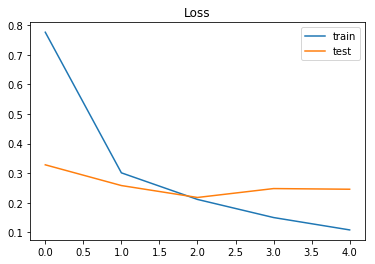

In [34]:
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

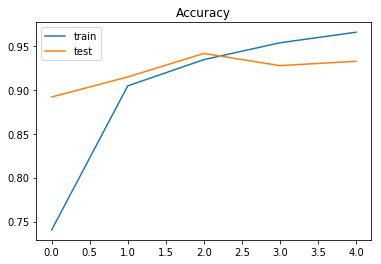

In [35]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();